In [1]:
from elasticsearch_dsl import Search
from elasticsearch import Elasticsearch
from elasticsearch.helpers import scan
from elasticsearch_dsl.query import Range, Term
from pathlib import Path
import fasttext
from detoxify import Detoxify
import csv
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from resiliparse.extract.html2text import extract_plain_text

/home/julian/info/Uni/thesis/toxic-bert/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
ELASTIC_HOST = "https://elasticsearch.srv.webis.de"
ELASTIC_PORT = 9200
ELASTIC_USER = "po87xox"
# As a way to hide the password at least from the notebook, enter a path to a file here, which only contains the password for Elastic.
ELASTIC_PASSWORD_FILE = Path("../../data/passwords/webis-elasticsearch.txt").expanduser()
INDEX = "corpus_mastodon_statuses*"

OUTPUT_PATH = Path("../data")

# Limit the Elastic searches to a specific date range. Crawling started on 2023-12-21.
DATE_AFTER = "2023-12-01T00:00:00"
## Ca. "2024-01-30T12:00:00" is the time when a new version of the fediverse data was gahtered.
DATE_BEFORE = "2024-02-22T00:00:00"

In [9]:
# Connect to Elastic.
with ELASTIC_PASSWORD_FILE.open("r") as f:
    password = f.readline().strip("\n")
es = Elasticsearch(
    [ELASTIC_HOST],
    port=ELASTIC_PORT,
    http_auth=(ELASTIC_USER, password),
    timeout=3000,
    scheme="https"
)

In [10]:
# Prepare the date query
date_query = Range(crawled_at={"gte": DATE_AFTER, "lte": DATE_BEFORE, "format" : "date_hour_minute_second"})
date_query.to_dict()

{'range': {'crawled_at': {'gte': '2023-12-01T00:00:00',
   'lte': '2024-02-22T00:00:00',
   'format': 'date_hour_minute_second'}}}

In [11]:
base_search: Search = Search(using=es, index=INDEX).filter(date_query)

In [16]:
from elasticsearch_dsl import Search, A

def get_all_instances(es):
    aggregation = A('terms', field='instance.keyword', size=100000)
    search = Search(index=INDEX).using(es)
    search.aggs.bucket('unique_instances', aggregation)    
    response = search.execute()
    
    instances = []
    buckets = response.aggregations.unique_instances.buckets
    for bucket in buckets:
        instances.append(bucket.key)
    
    return instances

In [17]:
instances = get_all_instances(es)

In [18]:
len(instances)

22408

In [13]:
instances = ["mastodon.social", "veganism.social", "pawoo.net", "shitposter.club", "social.coop", "scholar.social", "qoto.org"]
language_name = "en"

filtered_searches: Search = [base_search.filter(Term(instance=instance)).filter(Term(language=language_name)) for instance in instances]

In [9]:
lang_detector = fasttext.load_model('../models/lid.176.bin')

In [27]:
from transformers import pipeline

toxic_bert = pipeline(
     'text-classification', 
     model='unitary/toxic-bert', 
     tokenizer='bert-base-uncased', 
     function_to_apply='sigmoid', 
     return_all_scores=True
     )

/home/julian/info/Uni/thesis/toxic-bert/venv/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/home/julian/info/Uni/thesis/toxic-bert/venv/lib/python3.10/site-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [28]:
class Toxicity:
    def __init__(self, toxicity=0, severe_toxicity=0, obscene=0, threat=0, insult=0, identity_attack=0):
        self.toxicity = toxicity
        self.severe_toxicity = severe_toxicity
        self.obscene = obscene
        self.threat = threat
        self.insult = insult
        self.identity_attack = identity_attack
    
    def __add__(self, other):
        return Toxicity(
            self.toxicity + other.toxicity,
            self.severe_toxicity + other.severe_toxicity,
            self.obscene + other.obscene,
            self.threat + other.threat,
            self.insult + other.insult,
            self.identity_attack + other.identity_attack
        )
    
    def __truediv__(self, other):
        return Toxicity(
            self.toxicity / other,
            self.severe_toxicity / other,
            self.obscene / other,
            self.threat / other,
            self.insult / other,
            self.identity_attack / other
        )
    
    def __str__(self):
        return f"Toxicity: {self.toxicity}, Severe Toxicity: {self.severe_toxicity}, severe_toxicity: {self.obscene}, Threat: {self.threat}, Insult: {self.insult}, Identity Attack: {self.identity_attack}"
    
    @classmethod
    def from_prediction(cls, prediction):
        scores = {item['label']: item['score'] for item in prediction[0]}
        return cls(
            toxicity=scores.get('toxic', 0),
            severe_toxicity=scores.get('severe_toxic', 0),
            obscene=scores.get('obscene', 0),
            threat=scores.get('threat', 0),
            insult=scores.get('insult', 0),
            identity_attack=scores.get('identity_hate', 0)
        )

In [29]:
def predict_toxicity(hit):
    valid = True
    plaintext = extract_plain_text( hit['_source']['content'],
                                    main_content=True,
                                    alt_texts=False,
                                    preserve_formatting=False )
    
    lang = lang_detector.predict(plaintext)[0][0]

    if lang == '__label__en':
        prediction = toxic_bert.predict(plaintext)
        toxicity = Toxicity.from_prediction(prediction)
    else:
        valid = False
        toxicity = Toxicity()

    return toxicity, valid

def measure_toxicity(filtered_search):
    toxicity_sum = Toxicity()
    toxicitys = []

    it = scan(client=es, query=filtered_search.to_dict(), index=INDEX, size=1000)

    count = 0
    for hit in it:
        if count >= 10:
            break 
        
        toxicity, valid = predict_toxicity(hit)
        if valid:
            toxicity_sum += toxicity
            toxicitys.append(toxicity)
            count += 1
    
    valid_size = len(toxicitys)
    
    if valid_size > 0:
        toxicity_sum /= valid_size
    
    return toxicity_sum, toxicitys

In [35]:
toxic_bert.predict("You are gay or antisemmitian? Archangel WHite Tiger Meow! Greetingshhh! Uh, there are two ways, why you do erased my comment about WW2, that holocaust was brutally slaying of Jews and not gays/Gypsys/Slavs/anyone... 1 - If you are anti-semitian, than shave your head bald and go to the skinhead meetings! 2 - If you doubt words of the Bible, that homosexuality is a deadly sin, make a pentagram tatoo on your forehead go to the satanistic masses with your gay pals! 3 - First and last warning, you fucking gay - I won't appreciate if any more nazi shwain would write in my page! I don't wish to talk to you anymore! Beware of the Dark Side!")

[[{'label': 'toxic', 'score': 0.9973568916320801},
  {'label': 'severe_toxic', 'score': 0.5499579906463623},
  {'label': 'obscene', 'score': 0.9620006084442139},
  {'label': 'threat', 'score': 0.17852778732776642},
  {'label': 'insult', 'score': 0.9488321542739868},
  {'label': 'identity_hate', 'score': 0.9213958382606506}]]

In [27]:
toxicity_sum_mastodon_social, toxicitys_mastodon_social = measure_toxicity(filtered_searches[0])

In [168]:
toxicity_sum_veganism_social, toxicitys_veganism_social = measure_toxicity(filtered_searches[1])

In [155]:
toxicity_sum_pawoo_net, toxicitys_pawoo_net = measure_toxicity(filtered_searches[2])

In [169]:
print(len(toxicitys_mastodon_social))
print(len(toxicitys_veganism_social))
print(len(toxicitys_pawoo_net))

10000
10000
4805


In [172]:
def create_data_dict(data_list, source_label):
    """
    Creates a data dictionary from a list of objects for a specific source.

    Parameters:
    - data_list: List of objects, each containing attributes for the data.
    - source_label: Label for the source of the data.

    Returns:
    - Dictionary with data for different columns and source label.
    """
    data_dict = {
        "toxicity": [obj.toxicity for obj in data_list],
        "severe_toxicity": [obj.severe_toxicity for obj in data_list],
        "obscene": [obj.obscene for obj in data_list],
        "threat": [obj.threat for obj in data_list],
        "insult": [obj.insult for obj in data_list],
        "identity_attack": [obj.identity_attack for obj in data_list],
        "source": [source_label] * len(data_list)
    }
    
    return data_dict

# Beispielaufruf der Funktion
data_mastodon = create_data_dict(toxicitys_mastodon_social, 'mastodon.social')
data_veganism = create_data_dict(toxicitys_veganism_social, 'veganism.social')
data_pawoo = create_data_dict(toxicitys_pawoo_net, 'pawoo.net')


# Zusammenführen der Daten in ein DataFrame
df_mastodon = pd.DataFrame(data_mastodon)
df_veganism = pd.DataFrame(data_veganism)
df_pawoo = pd.DataFrame(data_pawoo)

df_combined = pd.concat([df_mastodon, df_veganism, df_pawoo], ignore_index=True)


/tmp/ipykernel_422120/848162658.py:7: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:k'` for the same effect.

  sns.stripplot(x="variable", y="value", hue="source",


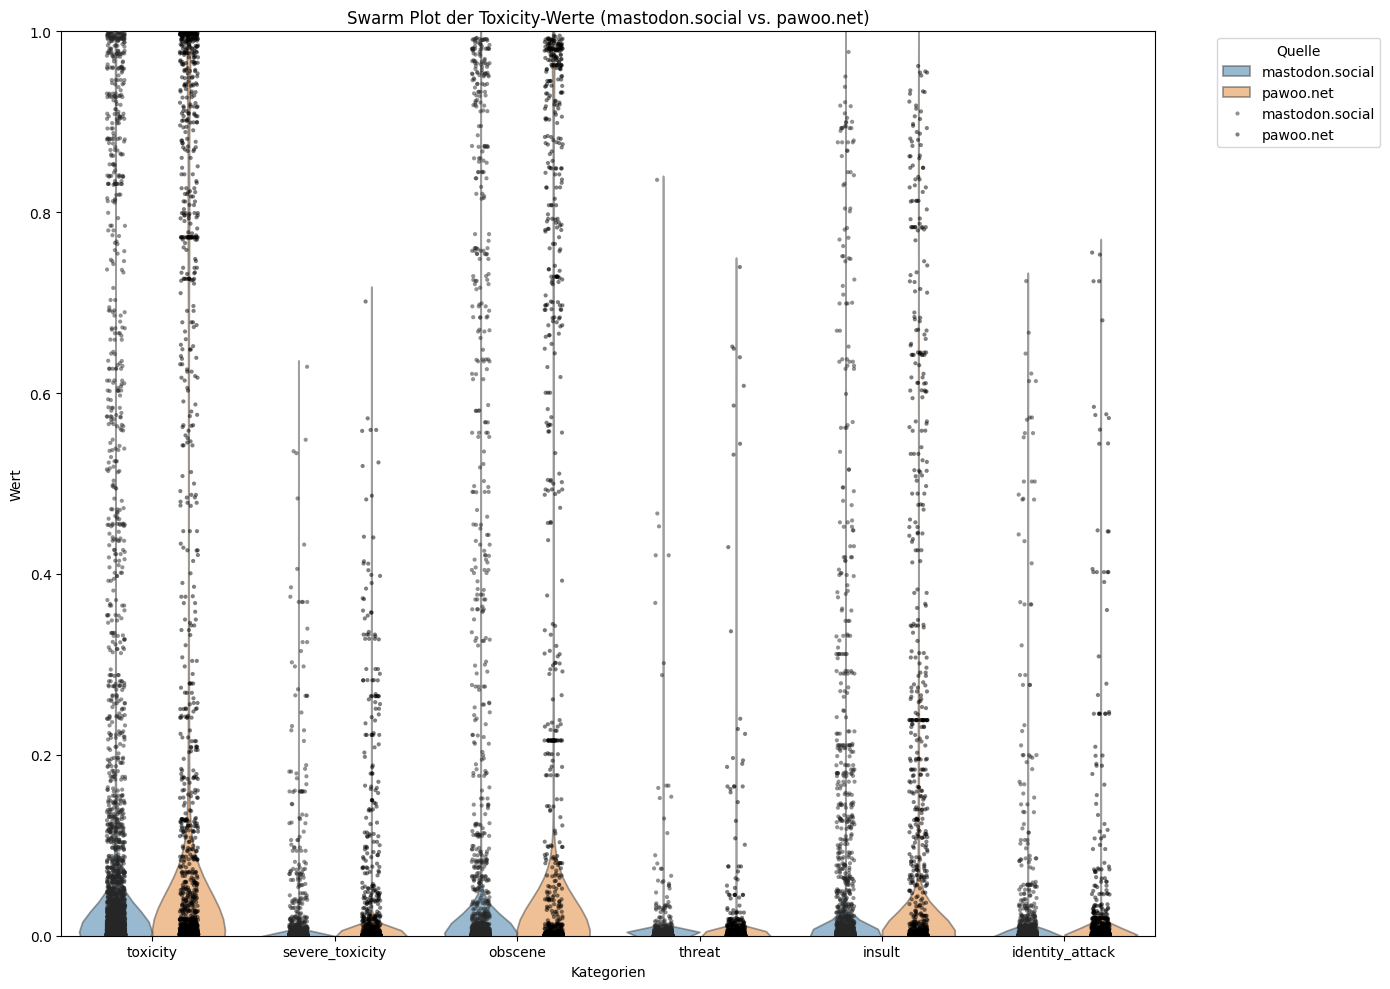

In [163]:
# Violinplot mit Stripplot erstellen
plt.figure(figsize=(14, 10))
sns.violinplot(x="variable", y="value", hue="source", 
               data=pd.melt(df_combined, id_vars=["source"], 
                            value_vars=["toxicity", "severe_toxicity", "obscene", "threat", "insult", "identity_attack"]), 
               density_norm='width', inner=None, alpha=0.5)
sns.stripplot(x="variable", y="value", hue="source", 
              data=pd.melt(df_combined, id_vars=["source"], 
                           value_vars=["toxicity", "severe_toxicity", "obscene", "threat", "insult", "identity_attack"]),
              dodge=True, color='k', alpha=0.5, size=3)
plt.title("Swarm Plot der Toxicity-Werte (mastodon.social vs. pawoo.net)")
plt.xlabel("Kategorien")
plt.ylabel("Wert")
plt.ylim(0, 1)  # Werte liegen zwischen 0 und 1
plt.legend(title="Quelle", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


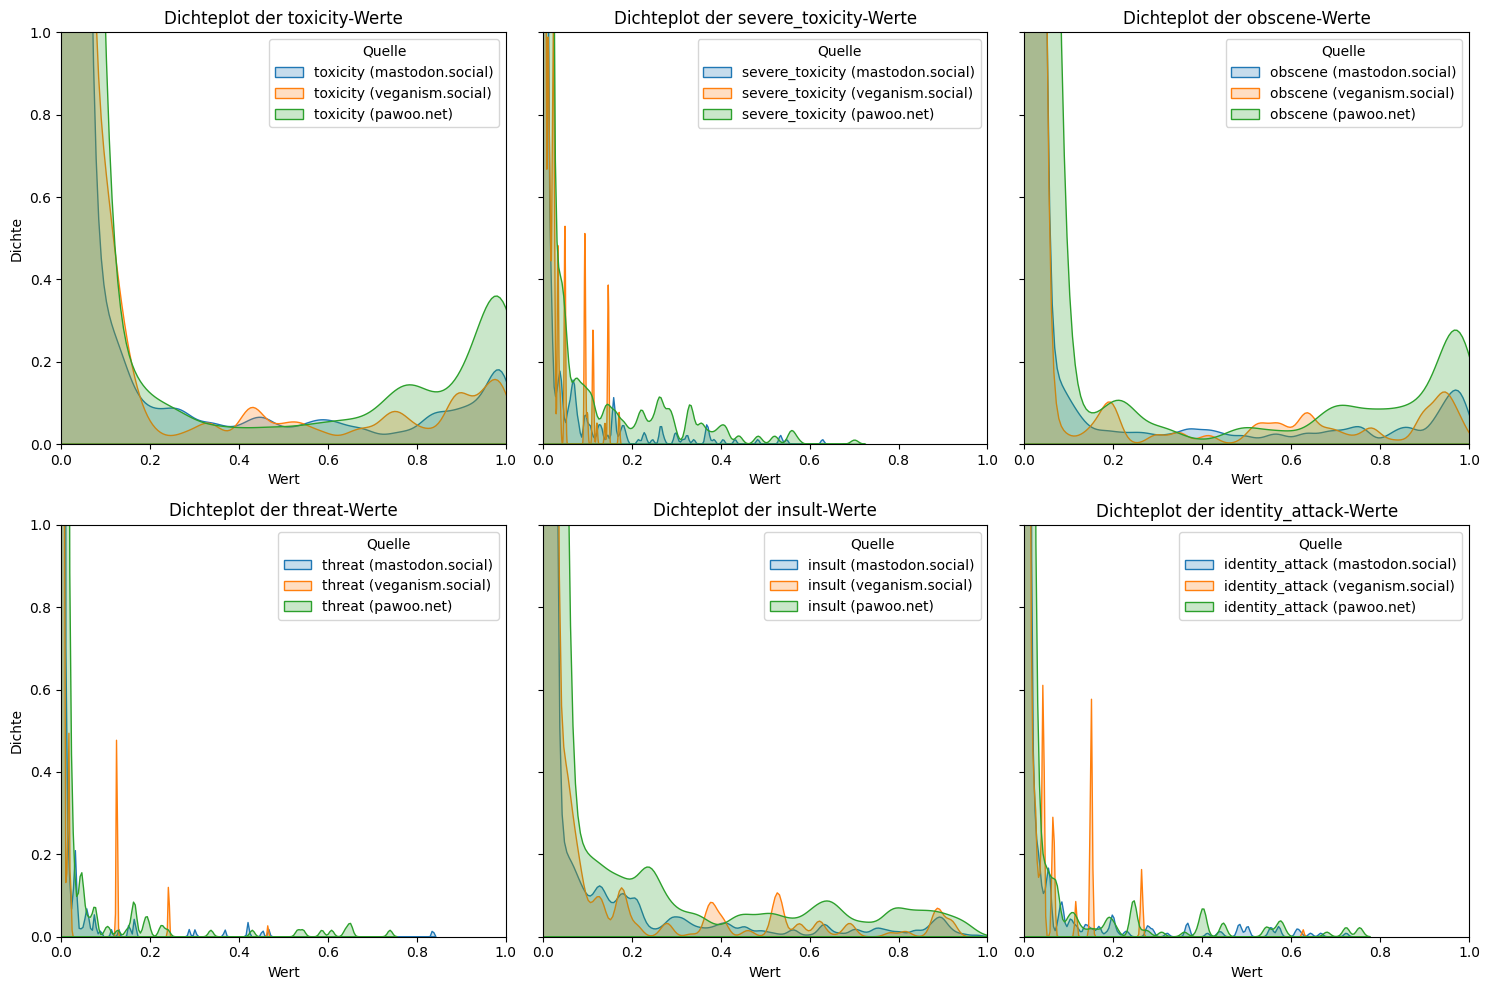

In [175]:

def plot_density(df, sources, columns, figsize=(15, 10)):
    """
    Plots density plots for specified columns from multiple sources.
    
    Parameters:
    - df: DataFrame with the data to plot
    - sources: List of sources to plot
    - columns: List of column names to plot
    - figsize: Tuple specifying the figure size
    """
    num_cols = len(columns)
    num_rows = (num_cols + 2) // 3  # Calculate the number of rows needed
    
    fig, axs = plt.subplots(num_rows, 3, figsize=figsize, sharey=True)
    axs = axs.flatten()  # Flatten to easily index the axes
    
    for i, column in enumerate(columns):
        for source in sources:
            sns.kdeplot(df[df['source'] == source][column], 
                        label=f'{column} ({source})', fill=True, ax=axs[i])
        axs[i].set_title(f"{column}-Werte")
        axs[i].set_xlabel("Wert")
        axs[i].set_ylabel("Dichte")
        axs[i].set_xlim(0, 1)
        axs[i].set_ylim(0, 1)
        axs[i].legend(title="Quelle")
    
    # Hide unused subplots
    for j in range(num_cols, len(axs)):
        axs[j].axis('off')
    
    plt.tight_layout()
    plt.show()

# Beispielaufruf der Funktion
columns = ['toxicity', 'severe_toxicity', 'obscene', 'threat', 'insult', 'identity_attack']
sources = ['mastodon.social', 'veganism.social', 'pawoo.net']
plot_density(df_combined, sources, columns)

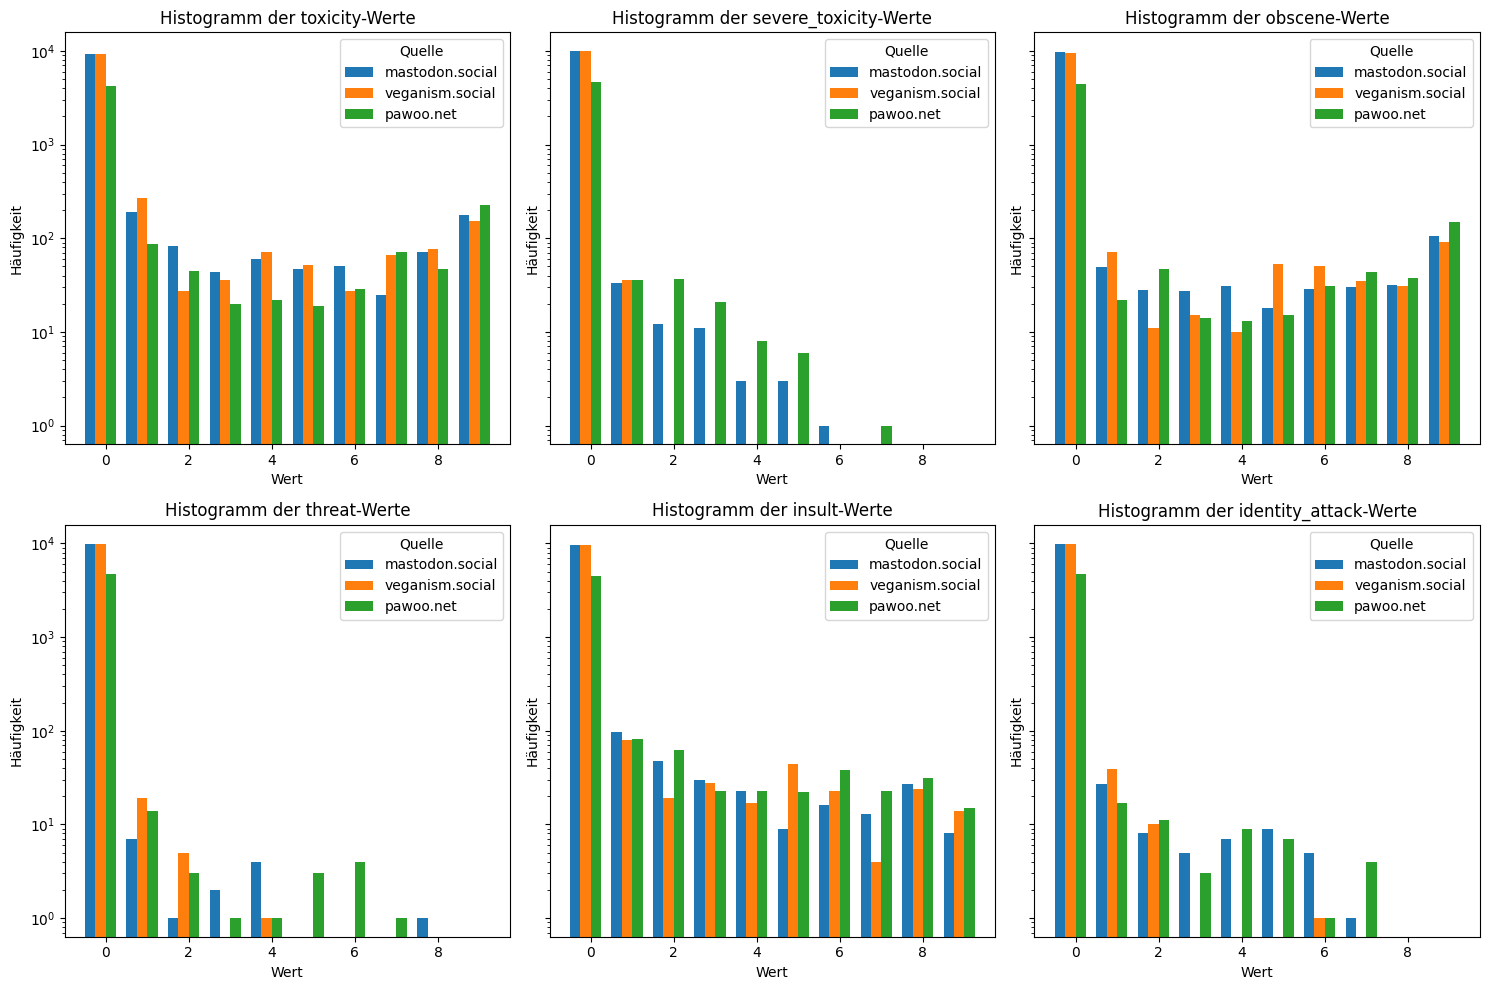

In [206]:
import matplotlib.pyplot as plt
import numpy as np

def plot_histograms(df, sources, columns, bins=10, figsize=(15, 10)):
    """
    Plots histograms for specified columns from multiple sources with bars grouped by source.
    
    Parameters:
    - df: DataFrame with the data to plot
    - sources: List of sources to plot
    - columns: List of column names to plot
    - bins: Number of bins for the histogram
    - figsize: Tuple specifying the figure size
    """
    num_cols = len(columns)
    num_rows = (num_cols + 2) // 3  # Calculate the number of rows needed
    
    fig, axs = plt.subplots(num_rows, 3, figsize=figsize, sharey=True)
    axs = axs.flatten()  # Flatten to easily index the axes
    
    width = 1 / (len(sources) + 1)  # Width of each bar
    
    for i, column in enumerate(columns):
        # Get histogram data for each source
        hist_data = {}
        for source in sources:
            data = df[df['source'] == source][column].dropna()
            counts, edges = np.histogram(data, bins=bins, range=(0, 1))
            hist_data[source] = (counts, edges)
        
        # Plot histograms for each source
        x = np.arange(bins)  # X locations for the bins
        for j, (source, (counts, edges)) in enumerate(hist_data.items()):
            offset = (j - len(sources) / 2) * width  # Offset for each source
            axs[i].bar(x + offset, counts, width=width, label=f'{source}')
        
        axs[i].set_title(f"Histogramm der {column}-Werte")
        axs[i].set_xlabel("Wert")
        axs[i].set_ylabel("Häufigkeit")
        axs[i].set_yscale('log')  # Set y-axis to logarithmic scale
        axs[i].legend(title="Quelle")
    
    # Hide unused subplots
    for j in range(num_cols, len(axs)):
        axs[j].axis('off')
    
    plt.tight_layout()
    plt.show()

columns = ['toxicity', 'severe_toxicity', 'obscene', 'threat', 'insult', 'identity_attack']
sources = ['mastodon.social', 'veganism.social', 'pawoo.net']
plot_histograms(df_combined, sources, columns)



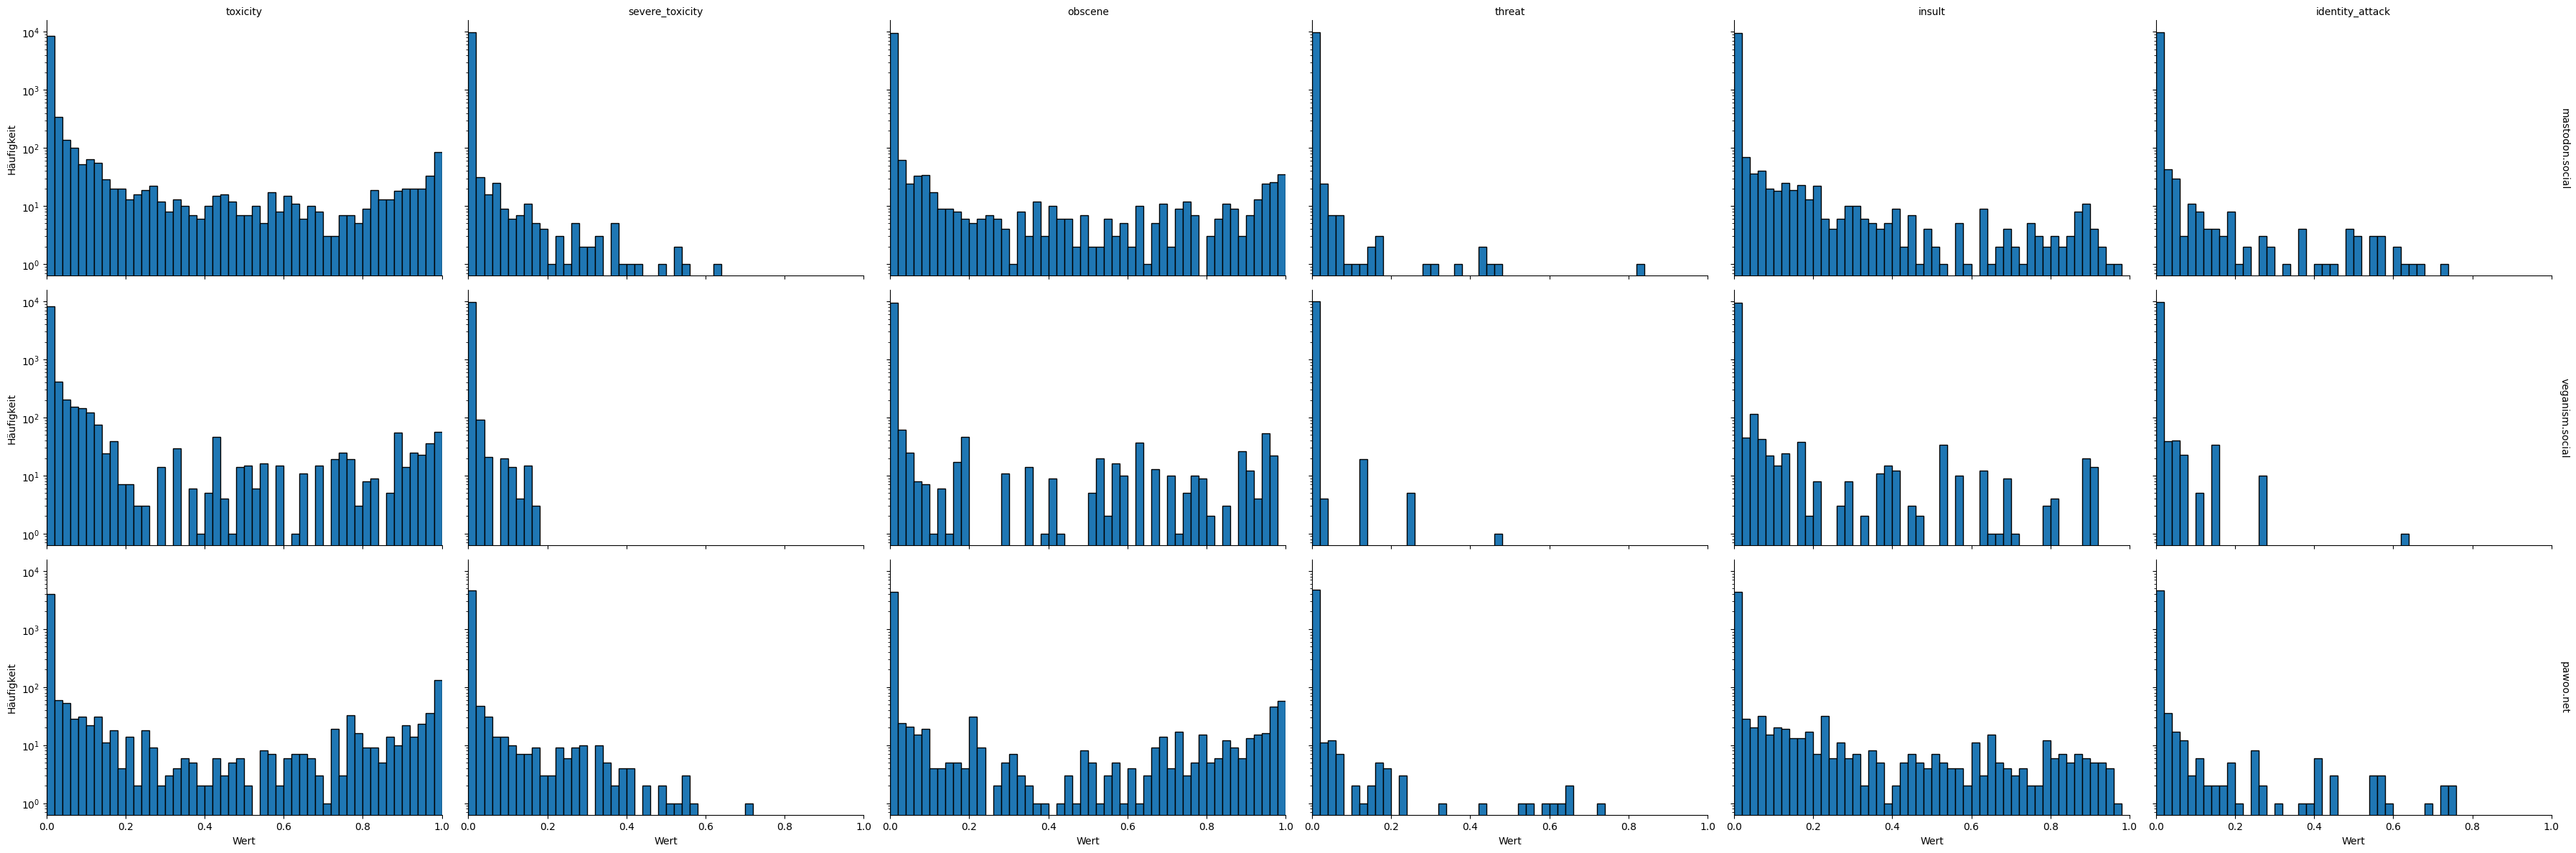

In [209]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_histograms(df, sources, columns, bins=50, figsize=(15, 15)):
    """
    Plots histograms for specified columns from multiple sources using faceting.
    
    Parameters:
    - df: DataFrame with the data to plot
    - sources: List of sources to plot
    - columns: List of column names to plot
    - bins: Number of bins for the histogram
    - figsize: Tuple specifying the figure size
    """
    # Melt the dataframe to long format for faceting
    df_long = pd.melt(df, id_vars=['source'], value_vars=columns, var_name='metric', value_name='value')

    # Set up the FacetGrid
    g = sns.FacetGrid(df_long, col='metric', row='source', margin_titles=True, height=4, aspect=1.5)
    
    # Map the histograms to the FacetGrid
    g.map(plt.hist, 'value', bins=bins, range=(0, 1), edgecolor='k')
    
    # Set the scale to logarithmic for all y-axes
    for ax in g.axes.flat:
        ax.set_yscale('log')
        ax.set_xlim(0, 1)
    
    # Set axis labels and titles
    g.set_axis_labels("Wert", "Häufigkeit")
    g.set_titles(col_template="{col_name}", row_template="{row_name}")
    
    plt.tight_layout()
    plt.show()

# Beispielaufruf der Funktion
columns = ['toxicity', 'severe_toxicity', 'obscene', 'threat', 'insult', 'identity_attack']
sources = ['mastodon.social', 'veganism.social', 'pawoo.net']
plot_histograms(df_combined, sources, columns)


In [17]:
csv_filename = 'toxicity_sums.csv'
with open(OUTPUT_PATH/csv_filename, 'w', newline='') as csvfile:
    csv_writer = csv.writer(csvfile)
    csv_writer.writerow(['Instance', 'Toxicity Sum'])
    for instance, toxicity_sum in zip(instances, toxicity_sums):
        csv_writer.writerow([instance, toxicity_sum])